In [1]:
#import midi_functions
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout, Flatten
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import callbacks
from keras import optimizers

from IPython.display import clear_output
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
input_length = 50
X_orig = np.loadtxt('notes/10clementiX.txt')
Y_orig = np.loadtxt('notes/10clementiY.txt')
#sorted_notes = np.loadtxt('notes/norm_sorted_notes.txt')
sorted_notes = np.unique(Y_orig)
n = X_orig.shape[0]
Y = np.copy(Y_orig)
max_note = np.max(Y)
min_note = np.min(Y)

X = X_orig / max_note #normalize input
n_notes_Y = n_hidden_units = len(sorted_notes)

for i,note in enumerate(Y): #make all the notes a number between 0 and number_of_different_notes
    Y[i] = np.where(sorted_notes == note)[0]
Y = np_utils.to_categorical(Y)

print('X={}, Y={}'.format(len(np.unique(X)),n_notes_Y))
print('Shape of X: {}'.format(X.shape))
print('Max: {}, Min: {}'.format(max_note, min_note))

X=38, Y=38
Shape of X: (9613, 10)
Max: 89.0, Min: 50.0


Text(0.5, 1.0, 'Full dataset with 9613 examples')

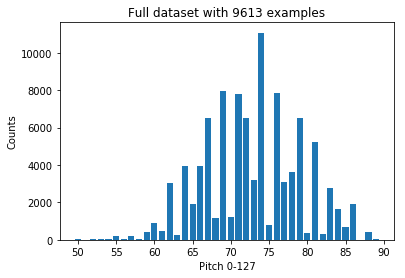

In [17]:
#Plots of note distribution
def prep_bar_plot(W):
    s = np.unique(W)
    counts = np.zeros(len(s))
    for i, note in enumerate(s):
        counts[i] = np.sum(W == note)
    return (s,counts)

s_notes, counts = prep_bar_plot(X_orig)
plt.bar(s_notes, counts)
plt.ylabel('Counts')
plt.xlabel('Pitch 0-127')
plt.title('Full dataset with {} examples'.format(len(X_orig)))

In [3]:
model = Sequential()
model.add(LSTM(
    256,
    input_shape=((input_length,1)),
    return_sequences=True
))
model.add(LSTM(n_hidden_units, return_sequences=False))
#model.add(Dropout(0.3))
model.add(Dense(n_hidden_units))
model.add(Activation('softmax'))
rmsprop = optimizers.RMSprop(lr=0.002, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
# Load the weights to each node
#model.load_weights('./hijacked_weights/10LSTM256-LSTM-400-0.2227.hdf5')
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 256)           264192    
_________________________________________________________________
lstm_2 (LSTM)                (None, 38)                44840     
_________________________________________________________________
dense_1 (Dense)              (None, 38)                1482      
_________________________________________________________________
activation_1 (Activation)    (None, 38)                0         
Total params: 310,514
Trainable params: 310,514
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
#Remember to change the name of the log file
class live_plot(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.index = 0
        self.epochs = []
        
        self.losses = []
        self.val_losses = []
        
        self.acc = []
        self.val_acc = []
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.epochs.append(self.index)
        
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs['val_acc'])
        self.index += 1
        
        clear_output(wait=True)
        plt.plot(self.epochs, self.losses, label="loss")
        plt.plot(self.epochs, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
        plt.plot(self.epochs, self.acc, label="acc")
        plt.plot(self.epochs, self.val_acc, label="val_acc")
        plt.legend()
        plt.show();
        
class dump_to_file(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        with open('logs/forplot_normalized_log.txt','wb') as f:
            np.savetxt(f,np.array([logs.get('loss'),logs.get('val_loss'),logs.get('acc'),logs.get('val_acc')]))

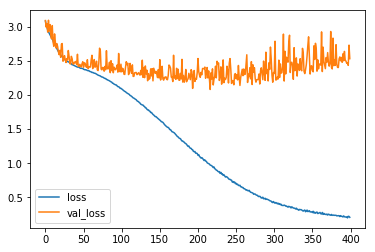

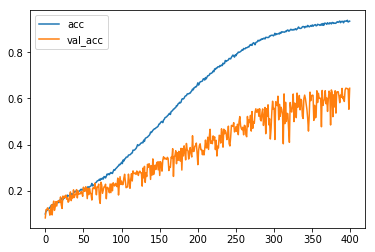

In [7]:
filepath = "./weights/clementi_normal/forplot{epoch:02d}.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)

plot = live_plot()
dump = dump_to_file()

callbacks_list = [checkpoint, plot, dump]     
fit_data = model.fit(X.reshape(n, input_length, 1), Y, validation_split=0.20,epochs=400, batch_size=64, callbacks=callbacks_list)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


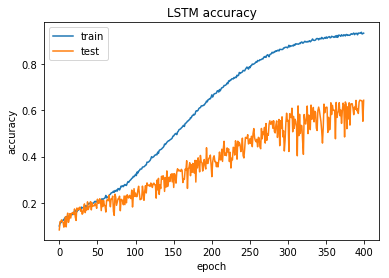

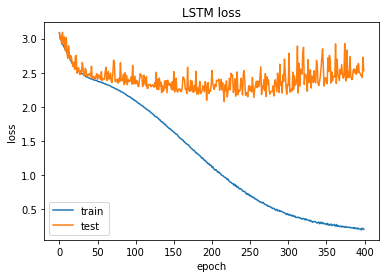

In [10]:
print(fit_data.history.keys())
# summarize history for accuracy
#plt.figure(figsize=(15,10))
plt.plot(fit_data.history['acc'])
plt.plot(fit_data.history['val_acc'])
plt.title('LSTM accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy_training.pdf')
plt.show()
# summarize history for loss
#plt.figure(figsize=(15,10))
plt.plot(fit_data.history['loss'])
plt.plot(fit_data.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.savefig('loss_training.pdf')
plt.show()

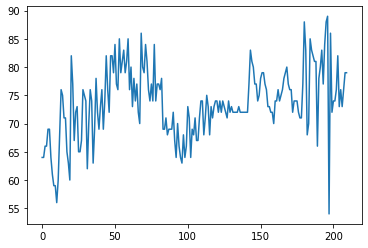

In [11]:
#Generate 200 notes
#model.load_weights('./hijacked_weights/hijacked-125.hdf5')
#random sequence to initialize predictions
init = X[np.random.randint(0,len(X))]

predicted_notes = np.zeros(200 + input_length)
predicted_notes[0:input_length] = init

for note_index in range(200):
    x = predicted_notes[note_index:note_index + input_length]
    prediction = model.predict(x.reshape(1,input_length,1))
    predicted_notes[note_index + input_length] = sorted_notes[np.argmax(prediction)] / max_note
predicted_notes = predicted_notes * max_note
plt.plot(predicted_notes)

In [12]:
predicted_notes

array([64., 64., 66., 66., 69., 69., 64., 61., 59., 59., 56., 60., 68.,
       76., 75., 71., 71., 65., 63., 60., 82., 77., 67., 72., 73., 65.,
       65., 67., 76., 75., 74., 62., 70., 76., 74., 63., 69., 78., 72.,
       69., 73., 76., 69., 74., 82., 76., 72., 82., 82., 79., 84., 77.,
       76., 85., 79., 81., 83., 79., 81., 85., 76., 80., 73., 78., 74.,
       77., 72., 70., 86., 80., 79., 84., 81., 76., 74., 77., 74., 84.,
       74., 77., 77., 76., 78., 69., 69., 71., 68., 69., 69., 69., 72.,
       67., 64., 70., 66., 64., 63., 68., 64., 66., 73., 71., 64., 69.,
       68., 71., 67., 67., 71., 74., 74., 68., 71., 75., 73., 68., 73.,
       71., 73., 74., 74., 72., 74., 72., 74., 73., 72., 71., 74., 72.,
       73., 72., 72., 72., 72., 73., 72., 72., 72., 72., 72., 72., 77.,
       83., 81., 80., 77., 77., 74., 75., 78., 79., 79., 77., 76., 73.,
       73., 72., 72., 70., 74., 74., 76., 74., 75., 76., 78., 79., 80.,
       77., 76., 76., 72., 74., 74., 74., 72., 71., 71., 77., 88

In [7]:
midi_functions.create_midi_from_notes(predicted_notes, on=250)

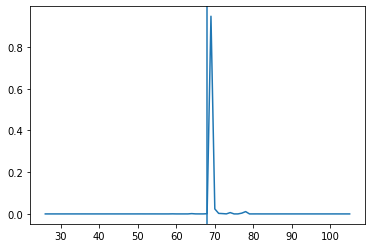

In [19]:
#see what the ouput of softmax looks like
x = X[np.random.randint(0,len(X))]
prediction = model.predict(x.reshape(1,input_length,1))
plt.plot(sorted_notes, prediction.reshape(n_notes_Y))
plt.axvline(x=x[input_length - 1] * max_note)

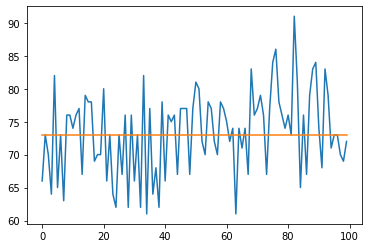

In [20]:
def generate_music_with_bias(bias):
    length = len(bias)
    init = X[np.random.randint(0,len(X))] #Picks out a random training example to begin generation

    predicted_notes = np.zeros(length + input_length)
    predicted_notes[0:input_length] = init
    #predicted_notes[9] = mean / max_note
    
    for note_index, note in enumerate(bias):
        x[0:input_length - 1] = predicted_notes[note_index:note_index + input_length - 1]
        x[input_length - 1] = note / max_note
        prediction = model.predict(x.reshape(1,input_length,1))
        predicted_notes[note_index + input_length] = sorted_notes[np.argmax(prediction)] / max_note
    
    return predicted_notes[input_length:] * max_note
    
bias = np.ones(100) * 73
predicted_notes = generate_music_with_bias(bias)
plt.plot(predicted_notes)
plt.plot(bias)

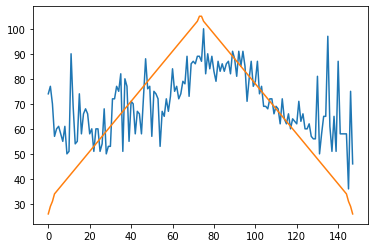

In [21]:
bias = np.concatenate((sorted_notes, sorted_notes[::-1]))
predicted_notes = generate_music_with_bias(bias)
plt.plot(predicted_notes)
plt.plot(bias)

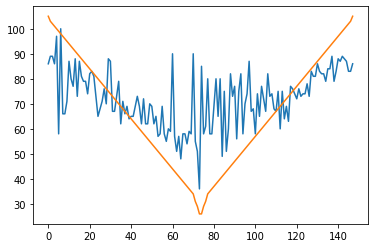

In [22]:
bias = np.concatenate((sorted_notes[::-1], sorted_notes))
predicted_notes = generate_music_with_bias(bias)
plt.plot(predicted_notes)
plt.plot(bias)

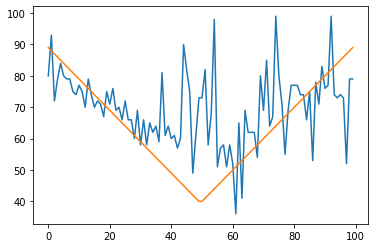

In [23]:
scale = np.arange(50) + 40
bias = np.concatenate((scale[::-1], scale))
predicted_notes = generate_music_with_bias(bias)
plt.plot(predicted_notes)
plt.plot(bias)

In [35]:
#Run this if you want to save the shortened data set
np.savetxt('balanced_shortened-X.txt',balanced_X_unnormalized,fmt='%i')
np.savetxt('balanced_shortened-Y.txt',balanced_Y,fmt='%i')
np.savetxt('balanced_shortened-sorted_notes.txt',balanced_sorted_notes,fmt='%i')

In [36]:
#Run this if you want to laod shortened data set
balanced_X = np.loadtxt('balanced_shortened-X.txt')
balanced_Y = np.loadtxt('balanced_shortened-Y.txt')
balanced_sorted_notes = np.loadtxt('balanced_shortened-sorted_notes.txt')
n_notes_balanced_X = len(np.unique(balanced_X))
n_notes_balanced_Y = n_balanced_hidden_units = len(balanced_sorted_notes)

balanced_X_unnormalized = np.copy(balanced_X)
balanced_X = balanced_X / max_balanced_note #normalize input

print('Make sure these numbers are the same: balanced_X={}, balanced_Y={}'.format(n_notes_balanced_X, n_notes_balanced_Y))
print('Number of different notes (hidden units): {}'.format(n_notes_balanced_Y))
print('Shape of balanced_X: {}'.format(balanced_X.shape))
print('balanced_Max: {}, balanced_Min: {}'.format(int(max_balanced_note), int(min_balanced_note)))

Make sure these numbers are the same: balanced_X=85, balanced_Y=82
Number of different notes (hidden units): 82
Shape of balanced_X: (10000, 10)
balanced_Max: 106, balanced_Min: 25


In [ ]:
def prep_bar_plot(W):
    s = np.unique(W)
    counts = np.zeros(len(s))
    for i, note in enumerate(s):
        counts[i] = np.sum(W == note)
    return (s,counts)

s_notes, counts = prep_bar_plot(balanced_X_unnormalized)
plt.bar(s_notes, counts)
plt.ylabel('Counts')
plt.xlabel('Pitch 0-127')
plt.title('Balanced dataset with {} examples'.format(len(balanced_X)))

In [ ]:
balanced_model = Sequential()
balanced_model.add(LSTM(
    256,
    input_shape=((input_length,1)),
    return_sequences=True
))
balanced_model.add(LSTM(n_balanced_hidden_units, return_sequences=False))
balanced_model.add(Dense(n_balanced_hidden_units))
balanced_model.add(Activation('softmax'))
rmsprop = optimizers.RMSprop(lr=0.002, rho=0.9, epsilon=None, decay=0.0)
balanced_model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
# Load the weights to each node
#model.load_weights('./hijacked_weights/10LSTM256-LSTM-400-0.2227.hdf5')
print(balanced_model.summary())

In [ ]:
filepath = "./weights/balanced-{epoch:02d}.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)

plot = live_plot()
dump = dump_to_file()

callbacks_list = [checkpoint, plot, dump]     
fit_data = balanced_model.fit(balanced_X.reshape(n, input_length, 1), balanced_Y, validation_split=0.20,epochs=400, batch_size=64, callbacks=callbacks_list)